# How accurate are our simulations of the Chandra PSF?
Chandra imaging can gives us the sharpest images of the X-ray sky ever seen and we recover details that could not be resolved by any other mission. For qualitative work, it is often necessary to know the detailed shape of the Chandra point-spread-function (PSF); unfortunately, there is no single, foolproof way to derive this since the PSF depends many things including the position of the source (the PSF degrades significantly off-axis), the spectrum of the source (hard X-rays scatter differently in the mirror than soft X-rays), the uncertainty of the aspect solution, the characteristics of the detector used (e.g. the pixel size in ACIS), and how the data is processed on the ground (e.g. if sub-pixel evend repositioning (EDSER) was applied).

In principle, the best possible PSF template is an observed point source with a similar spetrum, which was observed on the same position on the detector as the object we want to analyse. However, in practice this is very hard to find; not the least because bright sources cause pile-up in ACIS and faint sources do not provide enough signal to construct a high-fidelety PSF model. Thus, we frequently rely on models.

Link to psf central, chanrt, marx


In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [17]:
from glob import glob
import os

import numpy as np
from scipy.interpolate import interp1d
from astropy.table import Table
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
data_dir = '../../aspectblur'

In [4]:
def find_centroid(x, x0, width, func=np.mean):
    '''Find centroid of a distribution

    Parameters
    ----------
    x : np.array
    x0 : float
    starting guess
    width : float
    use only data values in ``x0 - width, x0 + width``
    func : callable
    '''
    ind = np.abs(x - x0) < width
    return func(x[ind])

In [5]:
def filter_data(obs):
    '''To reduce the background, cut to a region around the source and apply an energy filter
    In this energy range we have the most counts and we limited
    the simulations to the same range.
    
    This is most important for the observed data which does have some background, but 
    we apply the same filter to simulated ata, too, for consistency.
    '''
    ind = (obs['energy'] > 300) & (obs['energy'] < 3000)
    # reduce background by cutting in the likely region
    indposx = (obs['x'] > 4000) & (obs['x'] < 4150)
    indposy = (obs['y'] > 4000) & (obs['y'] < 4150)
    return obs[ind & indposx & indposy]

def bin_to_radial_histogram(data):
    centx = find_centroid(data['x'], 4096, 10)
    centy = find_centroid(data['y'], 4074, 10)

    xy = np.empty((2, len(data)))
    xy[0, :] = data['x'] - centx
    xy[1, :] = data['y'] - centy
    r = np.linalg.norm(xy, axis=0)

    return np.histogram(r, range=[0,5], bins=25)

In [6]:
def read_evttable(data, pix_adj, a_p_e = False, mirror = 'marx'):
    if pix_adj == 'edser':
        pix_adj_short = 'edser'
    elif pix_adj == 'randomize':
        pix_adj_short = 'rand'
    else:
        raise ValueError('Only pix_adj "edser" and "randomize" are supported.')
    if (data != 'obs') and mirror.lower() not in ['marx', 'saotrace']:
        raise ValueError('Mirror can only be simluated by "marx" or "saotrace".')
    if data == 'obs':
        if pix_adj.lower() == 'edser':
            return Table.read(os.path.join(data_dir, '15713', 'primary', 'acisf15713N002_evt2.fits'))
        else:
            return Table.read(os.path.join(data_dir, '15713', 'randomize', 'acisf15713_repro_evt2.fits'))
    else:
        if a_p_e is True:
            name = '{0}{1}a_p_e{2}.fits'.format(mirror, data, pix_adj_short)
        elif a_p_e is False:
            name = '{0}run{1}{2}.fits'.format(mirror, data, pix_adj_short)
        else:
            raise ValueError('a_p_e must be True or False.')
            
        data = Table.read(os.path.join(data_dir, name), hdu=1)
        if a_p_e is False:
            for c in data.colnames:
                 data.rename_column(c, c.lower())
        return data

In [7]:
def plot44(opt):
   
    # Read the observed data
    obs = read_evttable('obs', pix_adj=opt)
    obsfiltered = filter_data(obs)
    obshistval, obshistedges = bin_to_radial_histogram(obsfiltered)
    
    fig = plt.figure(figsize=(12, 10))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    
    # Plot observed data
    for ax in [ax1, ax3]:
        ax.plot(0.5 * (obshistedges[:-1] + obshistedges[1:]), 
             1.0 * obshistval.cumsum() / obshistval.sum(), 
             c='k', lw=5, label='Observation')

    for i in range(10):
        for prog, color in zip(['marx', 'saotrace'], 'rb'):
            for postproc, ls in zip(['', 'a_p_e'], '-:'):
                if postproc == '':
                    label = '{0}'.format(prog)
                    ls = '-'
                else:
                    label = '{0} + a_p_e'.format(prog)
                    ls = ':'
                data = read_evttable(i, opt, postproc=='a_p_e', prog)
                fdata = filter_data(data)
                histval, histedges = bin_to_radial_histogram(fdata)
                plotargs = {'alpha': 0.9, 'color': color, 'ls': ls}
                if i == 0:
                    plotargs['label'] = label            
    
                for ax in [ax1, ax3]:
                    ax.plot(0.5 * (histedges[1:] + histedges[:-1]),
                            1.0 * histval.cumsum() / histval.sum(),
                            **plotargs)
                for ax in [ax2, ax4]:
                    ax.plot(0.5 * (histedges[1:] + histedges[:-1]),
                            (1.0 * histval.cumsum() / histval.sum()) / (1.0 * obshistval.cumsum() / obshistval.sum()),
                             **plotargs)

    # Set polt labels, axis scale etc.
    for ax in [ax1, ax2, ax3, ax4]:
        ax.legend(loc='lower right')
        ax.set_title('ObsID 15713 - {0}'.format(opt.upper()))
        ax.set_xlabel('Radial distance from center [pix]')
    
    for ax in [ax1, ax2]:
        ax.set_xscale("log")
        ax.set_xlim([0.1, 5])
    
    for ax in [ax1, ax3]:
        ax.set_ylabel('ECF')

    for ax in [ax2, ax4]:
        ax.set_ylabel('ECF ratio simulated / observed')
        ax.plot(ax2.get_xlim(), [1, 1], 'k-')

    return fig

In [33]:
def plot44_reverse(opt):
   
    # Read the observed data
    obs = read_evttable('obs', pix_adj=opt)
    obsfiltered = filter_data(obs)
    obshistval, obshistedges = bin_to_radial_histogram(obsfiltered)
    
    fig = plt.figure(figsize=(12, 10))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    
    # Plot observed data
    for ax in [ax1, ax3]:
        obsecf = 1.0 * obshistval.cumsum() / obshistval.sum()
        obsradius = 0.5 * (obshistedges[:-1] + obshistedges[1:])
        ax.plot(obsecf, obsradius, c='k', lw=5, label='Observation')
        obsecfinterp = interp1d(obsradius, obsecf)

    for i in range(10):
        for prog, color in zip(['marx', 'saotrace'], 'rb'):
            for postproc, ls in zip(['', 'a_p_e'], '-:'):
                if postproc == '':
                    label = '{0}'.format(prog)
                    ls = '-'
                else:
                    label = '{0} + a_p_e'.format(prog)
                    ls = ':'
                data = read_evttable(i, opt, postproc=='a_p_e', prog)
                fdata = filter_data(data)
                histval, histedges = bin_to_radial_histogram(fdata)
                plotargs = {'alpha': 0.9, 'color': color, 'ls': ls}
                if i == 0:
                    plotargs['label'] = label            
    
                ecf = 1.0 * histval.cumsum() / histval.sum()
                radius = 0.5 * (histedges[1:] + histedges[:-1])
                for ax in [ax1, ax3]:
                    ax.plot(ecf, radius, **plotargs)
                for ax in [ax2, ax4]:
                    
                    ax.plot(ecf, obsecfinterp(radius) / ecf, 
                             **plotargs)

    # Set polt labels, axis scale etc.
    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_title('ObsID 15713 - {0}'.format(opt.upper()))
        ax.set_ylabel('Radial distance from center [pix]')
        ax.set_xlabel('ECF')
    
    for ax in [ax1, ax2]:
        ax.set_yscale("log")

    for ax in [ax1, ax3]:
        ax.legend(loc='upper left')
        
    for ax in [ax2, ax4]:
        ax.legend(loc='upper right')
        ax.set_ylabel('fractional ECF Error')
        ax.plot(ax2.get_ylim(), [1, 1], 'k-')
        ax.set_xlim([0, 1])

    return fig

## The radial profile of the PSF
### EDSER processed data

/nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in greater
/nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in less
/nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater
/nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in less


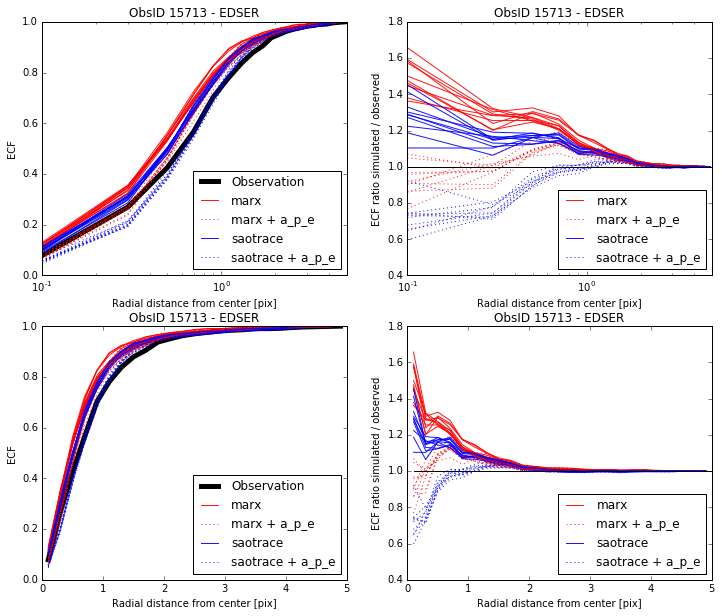

In [8]:
fig = plot44('edser')

**Fig. 1** Comparison of the encircled energy fraction for the central source of ObsID 15713 in observations and simulations. The top and bottom row show identical plots, except that the top row has a logarithmically scaled x-axis, while the bottom row has a linearly scaled axis to highlight different features. *left*: Encircled count fraction (ECF) as a function of radial distance from the center (see text for details). 

/nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in greater
/nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in less
/nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater
/nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in less


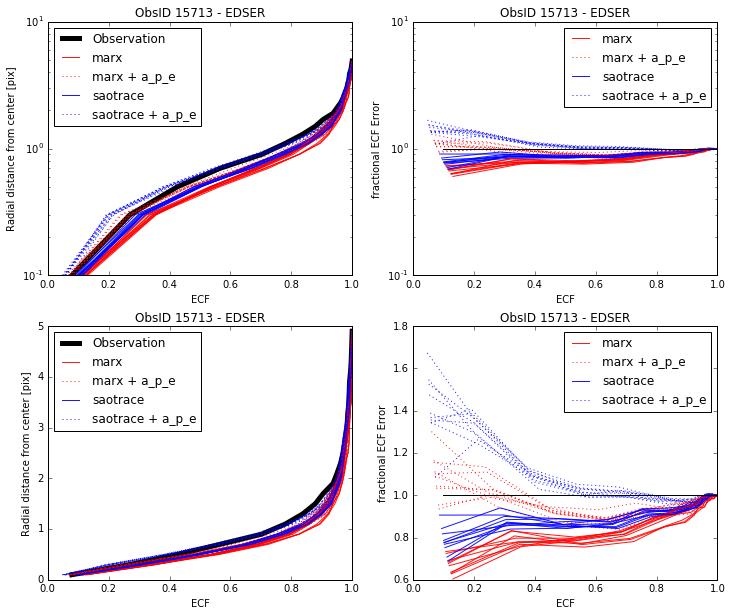

In [34]:
fig = plot44_reverse('edser')

**Fig 2**: This is plotting the same simulated data as in Fig 1, but with different axes. Now, the x-axis is the ECF. *left*: Plot show which radius needs to be selected to achieve a certein ECF, e.g. ECF90. This is just the same as the respective plots in Fig 1 with x and y axis exchanged. *right*: This estimates the error that one makes, when reading a radius of the left plots and runnnig with it, e.g. if the left plot is used to estimate the ECF90 for one of the normal marx runs (any red line) and then you go and extract the data in the observation with that radius. Since the MARX PSFs are too narrow (the same ECF is reached for a smaller radius compared to the observation) less than 90 % of the observed counts will be extracted and the source flux will be underestimated. Looking at the lower right plot, we see that using the ECF90, the extracted observed flux will be 10-20% too low.

### RANDOMIZE

/nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in greater
/nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in less
/nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater
/nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in less


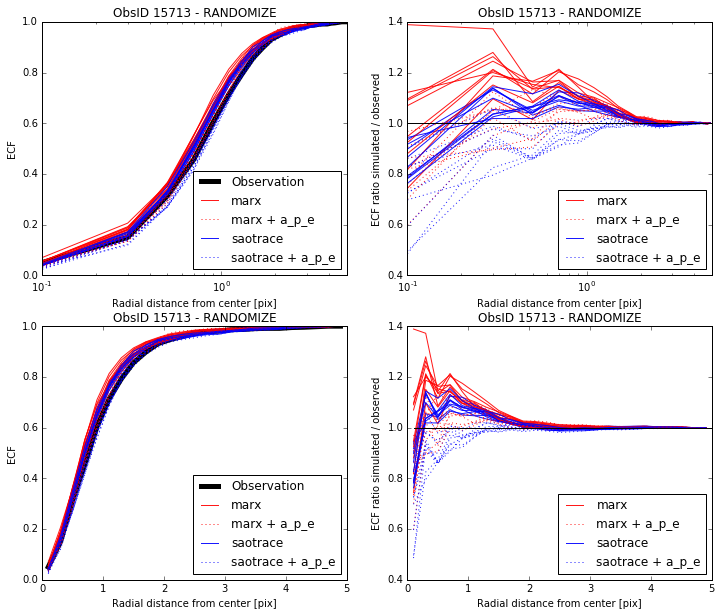

In [9]:
fig = plot44('randomize')

**Fig. 3** Same as Figure 1, but using the RANDOMIZE setting for both the data processing in [chandra_repro](http://cxc.harvard.edu/ciao/ahelp/chandra_repro.html) and in marx2fits.

/nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in greater
/nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in less
/nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater
/nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in less


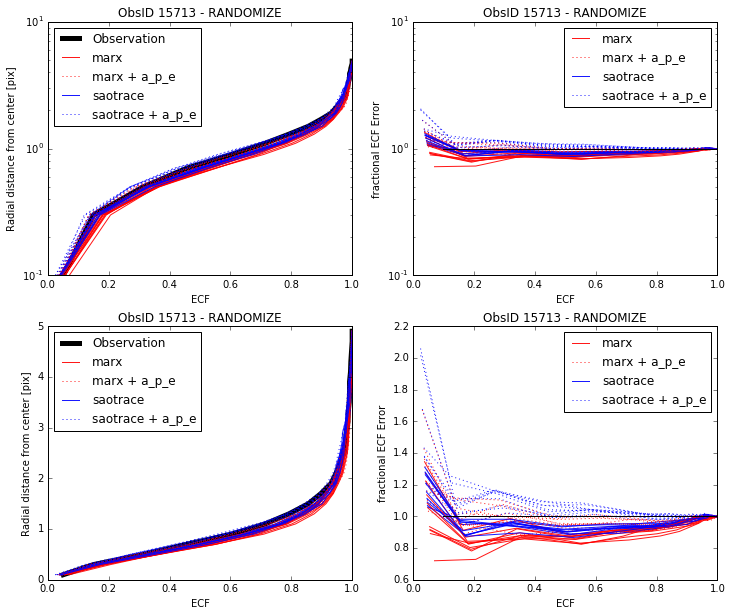

In [35]:
fig = plot44_reverse('randomize')

**Fig. 4** Same as Figure 2, but using the RANDOMIZE setting for both the data processing in [chandra_repro](http://cxc.harvard.edu/ciao/ahelp/chandra_repro.html) and in marx2fits.

## Grade distribution

In [10]:
colors = ['r', 'c', 'm', 'orange', 'g']

def plotpie(ax, fileargs, plotargs, col='grade'):
    d = filter_data(read_evttable(**fileargs))
    counts = np.bincount(d[col])
    labels = np.arange(len(counts))
    ind = counts > 0
    ax.pie(counts[ind], labels=labels[ind], colors = colors, autopct='%2i%%', **plotargs)

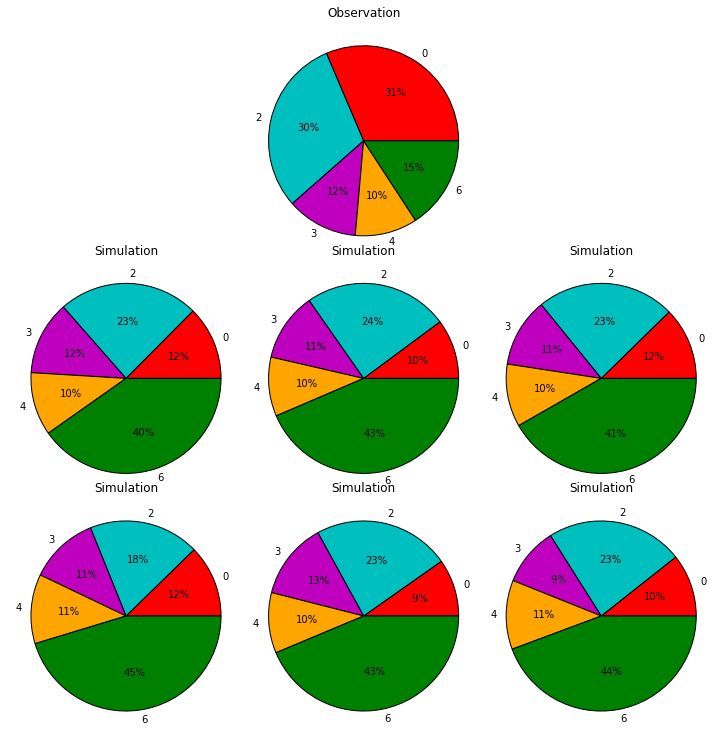

In [11]:
fig = plt.figure(figsize=(10, 10))
axobs = fig.add_axes([0.33, 0.66, 0.33, 0.33])
axobs.set_title('Observation')
plotpie(axobs, {'data':'obs', 'pix_adj': 'edser'}, {})

for i in range(3):
    for j, prog in enumerate(['marx', 'saotrace']):
        ax = fig.add_axes([i * 0.33, j * 0.33, 0.33, 0.33])
        ax.set_title('Simulation')
        plotpie(ax, {'data':i, 'pix_adj': 'edser', 'mirror': prog}, {})

**Figure** Observed (top) and simulated (bottom two rows) grade distribution. The simulation was run multiple times and six of those are shown here to illustrate the effect of poisson noise in the data (around 1000 photons per simulation). The pie charts show the "grade" in the ASCA system. The data is already filtered and only good grades (0, 2, 3, 6) are retained, so 0% is reported for grades 1 and 5.

The grade of an event is assigned at the spacecraft and not changed in ground processing, so the setting of "EDSER" or "RANDOMIZE" does not change the grade distribution of observed data. Similarly, *marx* assignes a grade by drawing from a distribution set in the program (in fact, a pixel is subdiveded into 3 \* 3 region and the draw differs based on the exact region where the ray hits the pixel plus some random component). Again, post-processing with *marx2fits* or *acis_process_events* does not change the event grade.

Thus, a single figure sufficies to compare the grade distribution in observed and simulated datasets. Compared to the observation, there are far too few grade "0" events in the simulated dataset by about a factor of three, and far too many grade "6" events. Grade "3" and "4" are consistent between observations and simulations, grade "2" is slightly underrepresented in the simulations.

The ASCA "grade" system is already a simplification of the more detailed flight grade (column "fltgrade" in the event files). The following plot loks into the flight grade distribution in a little more detail.

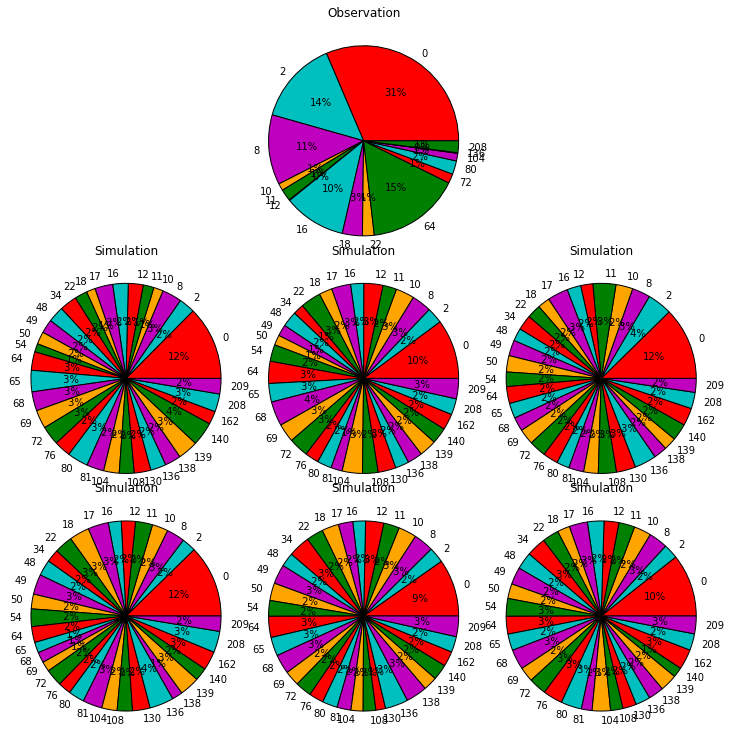

In [12]:
fig = plt.figure(figsize=(10, 10))
axobs = fig.add_axes([0.33, 0.66, 0.33, 0.33])
axobs.set_title('Observation')
plotpie(axobs, {'data':'obs', 'pix_adj': 'edser'}, {}, col='fltgrade')

for i in range(3):
    for j, prog in enumerate(['marx', 'saotrace']):
        ax = fig.add_axes([i * 0.33, j * 0.33, 0.33, 0.33])
        ax.set_title('Simulation')
        plotpie(ax, {'data':i, 'pix_adj': 'edser', 'mirror': prog}, {}, col='fltgrade')